# **GIS × Python Tutorial 7.2 ~ Rasterデータの投影変換 ~**
---
この記事は「GIS × Python Tutorial」の関連記事です。

<br>


## **1. はじめに**
---
前回の Tutorial 7.1 では `gdal` と `rasterio` でのデータの読み書きについて紹介しました。今回は GDAL での投影変換に関して解説していきます。

今回記事の執筆に使用した Notebook と Conda環境ファイル（geome.yaml）は GitHub に公開しているので、実行してみたい方はリポジトリーを覗いて下さい。
<br>

## **2. 投影変換とは**
---
投影変換はある座標系から別な座標系に変換する作業の事です。今回の記事では東北を含む平面直角座標系の「EPSG:6678」から「EPSG:4326」への変換を例に紹介していきます。

## **3. コード実行の準備**
---

### **3-1. Import**


In [6]:
import japanize_matplotlib
from matplotlib import pyplot as plt
import numpy as np
from osgeo import gdal, osr
import pyproj
import shapely
from shapely.plotting import plot_polygon
japanize_matplotlib.japanize()
osr.UseExceptions()

# 入力ファイルのSRSを設定
IN_EPSG = 6678
IN_SRS_WKT = pyproj.CRS(IN_EPSG).to_wkt()

# 出力ファイルのSRSを設定
OUT_EPSG = 4326
OUT_SRS_WKT = pyproj.CRS(OUT_EPSG).to_wkt()

### **3-2. Rasterデータの作成**
とりあえず最初に投影変換する為の Raster データを作成します。セルの形状が分かり易いように RGB のランダムな値を入れて作成します。

In [18]:
# データの作成
cols = 20
rows = 15
image = []
for _ in range(3):
    img = np.array([np.random.randint(0, 256, cols) for _ in range(rows)])
    image.append(img)
image = np.array(image)

# GDAL で RasterDataをインメモリーに保存
driver = gdal.GetDriverByName('MEM')
driver.Register()
org_dst = driver.Create(
    '',
    xsize=image[0].shape[1], 
    ysize=image[0].shape[0], 
    bands=3, 
    eType=gdal.GDT_Byte
)

# 弘前城の辺りを適当に指定して、分解能をxy=10mで作成
transform = (-31270.0, 10.0, 0.0, 67573.0, 0.0, -10.0)
org_dst.SetGeoTransform(transform)
org_dst.SetProjection(IN_SRS_WKT)
for i, img in enumerate(image, start=1):
    band = org_dst.GetRasterBand(i)
    band.WriteArray(img)

org_dst.FlushCache()

0

### **3-3. 作成した Raster の確認** 
次に RasterData の投影範囲を取得する関数と、RasterData を Plot する関数を作成し、作成した RasterData を確認してみます。

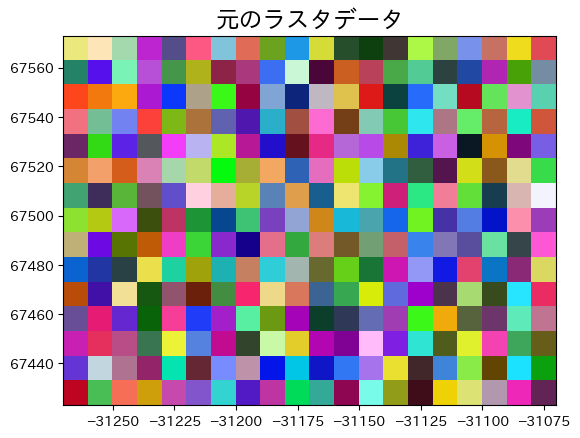

In [19]:
def get_bounds(dst: gdal.Dataset):
    # ラスタデータの範囲を取得する関数
    transform = dst.GetGeoTransform()
    x_min = transform[0]
    y_max = transform[3]
    rows = dst.RasterYSize
    cols = dst.RasterXSize
    x_resol = transform[1]
    y_resol = transform[-1]
    x_max = x_min + cols * x_resol
    y_min = y_max + rows * y_resol
    return (x_min, y_min, x_max, y_max)


def plot_raster(dst, title):
    # ラスタデータをプロットする関数
    raster = org_dst.ReadAsArray()
    bounds = get_bounds(dst)
    # Matplotlibで表示する範囲の指定
    extent = [bounds[0], bounds[2], bounds[1], bounds[3]]
    plt.title(title, fontsize=17, fontweight='bold')
    plt.imshow(np.dstack(raster), extent=extent)
    plt.show()



plot_raster(org_dst, '元のラスタデータ')

## **4. 投影変換**
---


### **4-1. 投影変換後の座標を取得する関数作成**
まずは後から検証に使用する為に投影変換後の Dataset から Raster の投影範囲を取得し、元の平面直角座標系の座標に戻す関数を作成しておきます。

In [20]:
def get_local_bounds(wgs_dst):
    # 投影変換後のデータの範囲を取得し、平面直角座標系に戻す
    transformer = pyproj.Transformer.from_crs(    
        crs_from=OUT_SRS_WKT,
        crs_to=IN_SRS_WKT,
        always_xy=True
    )
    bounds = get_bounds(wgs_dst)
    xx = [bounds[0], bounds[2]]
    yy = [bounds[1], bounds[3]]
    transformed = transformer.transform(xx, yy)
    x_min, x_max = transformed[0]
    y_min, y_max = transformed[1]
    return (x_min, y_min, x_max, y_max)

### **4-2. IOのSRSだけ指定した投影変換**

GDAL での投影変換は `gdal.Warp` で行います。最初は入力ファイルのSRSと出力ファイルのSRSのみを指定して投影変換を行ってみましょう。以下の方法は QGIS で投影変換した際の結果と同じになります。

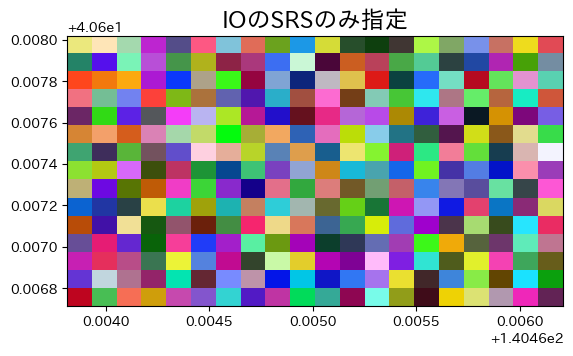

In [30]:
io_srs_dst = gdal.Warp(
    # 入力ファイルパス
    destNameOrDestDS='',
    srcDSOrSrcDSTab=org_dst,
    # オプション設定
    options=gdal.WarpOptions(
        # ファイルとして出力せずに、メモリ上に出力
        format='MEM',
        # 入力ファイルの空間参照系（EPSG:6678）
        srcSRS=org_dst.GetProjection(),
        # 出力ファイルの空間参照系（EPSG:4326）
        dstSRS=OUT_SRS_WKT,
        # リサンプリングアルゴリズム
        resampleAlg=gdal.GRA_CubicSpline
    )
)

# あとから検証に利用する
bounds_dict = {
    'Original': {
        'bounds': get_bounds(org_dst), 
        'x_size': org_dst.RasterXSize, 
        'y_size': org_dst.RasterYSize
    },
    'IOのSRSのみ指定': {
        'bounds': get_local_bounds(io_srs_dst), 
        'x_size': io_srs_dst.RasterXSize, 
        'y_size': io_srs_dst.RasterYSize
    }
}

plot_raster(io_srs_dst, 'IOのSRSのみ指定')

これで Raster データを投影変換する事ができます。非常に簡単ですが、Raster の投影変換には注意が必要です。

下の図をみて下さい投影変換後の範囲を元の SRS に投影変換（戻す）した範囲を Plot してみると、元の位置に戻っていない事が確認できます。また、Raster に記録した行列のサイズも変わっているのが分かります。VectorData と違い RasterData は点のデータではなく、面（セル）のデータなので、ピッタリと元の位置と同じ場所に投影変換する事は出来ず、不可逆の変換になっているようです。この為、`gdal.Warp` では `gdal.WarpOptions` の "resampleAlg" に引数を渡してこれまでなかったセルの値を補完しているはずです。大きな範囲の RasterData であれば、このままで構わないかもしれませんが、小さな範囲の RasterData でこの様に座標がズレて不可逆になるのは少し気持ち悪いので、`gdal.WarpOptions` を設定して変化があるのかを見てみましょう。

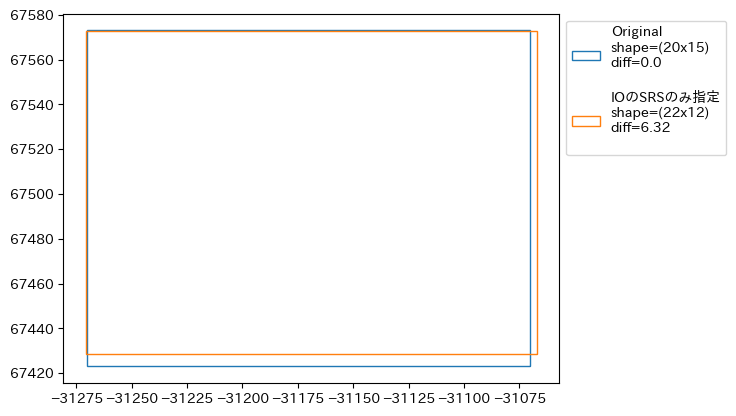

In [31]:
def plot_bounds(bounds_dict):
    # バウンディングボックスをプロットする関数
    # 
    base_bounds = bounds_dict['Original']['bounds']
    base_pt = shapely.Point(base_bounds[2], base_bounds[1])
    diff_lst = []
    for i, (label, item) in enumerate(bounds_dict.items()):
        _bounds = item.get('bounds')
        pt = shapely.Point(_bounds[2], _bounds[1])
        diff_lst.append(round(pt.distance(base_pt), 2))
    # バウンディングボックスをプロットする関数
    colors = plt.get_cmap('tab10').colors
    fig, ax = plt.subplots()
    for i, (label, items) in enumerate(bounds_dict.items()):
        geom = shapely.box(*items.get('bounds'))
        label = f"{label}\nshape=({items.get('x_size')}x{items.get('y_size')})\ndiff={diff_lst[i]}\n"
        plot_polygon(
            geom, ax, edgecolor=colors[i], facecolor='none', 
            label=label, add_points=False
        )
    plt.legend(bbox_to_anchor=(1., 1))
    plt.show()



plot_bounds(bounds_dict)

### **4-3. 出力後の範囲指定**
まずは投影変換後の座標値を指定してみましょう。出力座標値の指定は "outputBounds" で行います。今回は "EPSG:6678" -> "EPSG:4326" への変換なので、投影したい座標値を "EPSG:4326" で計算し、タプルに（x_min, y_min, x_max, y_max）の順で格納して渡します。

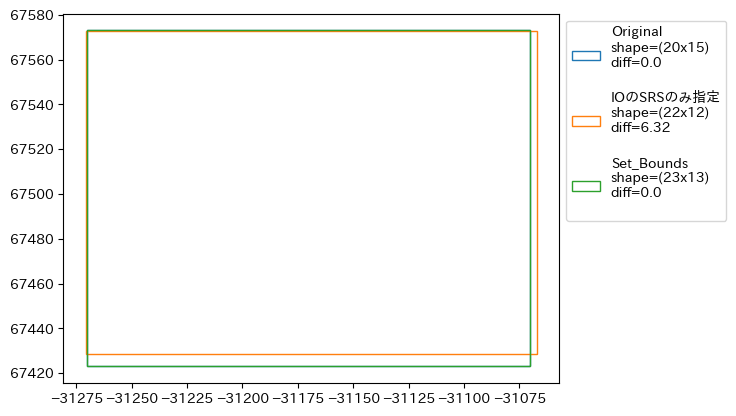

In [32]:
def reproject_bounds(org_dst, out_srs):
    # 投影変換後のデータの範囲を取得する
    bounds = get_bounds(org_dst)
    transformer = pyproj.Transformer.from_crs(    
        crs_from=org_dst.GetProjection(),
        crs_to=out_srs,
        always_xy=True
    )
    xx = [bounds[0], bounds[2]]
    yy = [bounds[1], bounds[3]]
    transformed = transformer.transform(xx, yy)
    x_min, x_max = transformed[0]
    y_min, y_max = transformed[1]
    return (x_min, y_min, x_max, y_max)



set_bounds_dst = gdal.Warp(
    destNameOrDestDS='',
    # 入力データセットあるいは入力ファイルパス
    srcDSOrSrcDSTab=org_dst,
    # オプション設定
    options=gdal.WarpOptions(
        # ファイルとして出力せずに、メモリ上に出力
        format='MEM',
        # 入力ファイルの空間参照系（EPSG:6678）
        srcSRS=org_dst.GetProjectionRef(),
        # 出力ファイルの空間参照系（EPSG:4326）
        dstSRS=OUT_SRS_WKT,
        # 出力ファイルの範囲を指定
        outputBounds=reproject_bounds(org_dst, OUT_SRS_WKT),
        # リサンプリングアルゴリズム
        resampleAlg=gdal.GRA_CubicSpline
    )
)

bounds_dict['Set_Bounds'] = {
    'bounds': get_local_bounds(set_bounds_dst),
    'x_size': set_bounds_dst.RasterXSize, 
    'y_size': set_bounds_dst.RasterYSize
}

plot_bounds(bounds_dict)

### **4-4. 出力後の範囲指定 & 行列のサイズ指定**

範囲のずれはなくなりました。しかし行列のサイズは変わったままです、行列のサイズも合わせてみましょう。行列のサイズは `width`、`hight` で指定します。

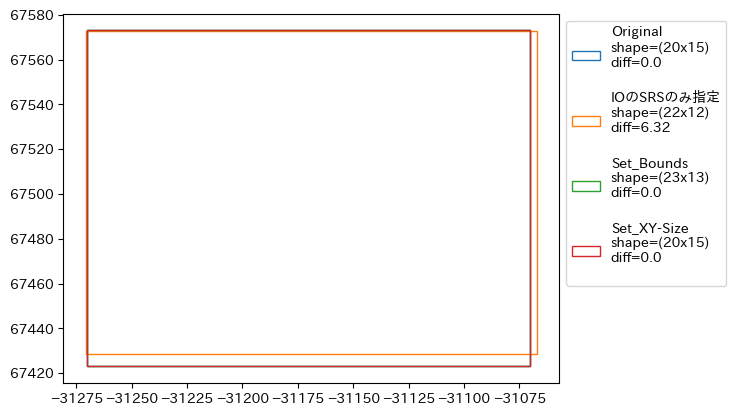

In [33]:
set_xy_size_dst = gdal.Warp(
    # 入力ファイルパス
    destNameOrDestDS='',
    srcDSOrSrcDSTab=org_dst,
    # オプション設定
    options=gdal.WarpOptions(
        # ファイルとして出力せずに、メモリ上に出力
        format='MEM',
        # 入力ファイルの空間参照系（EPSG:6678）
        srcSRS=org_dst.GetProjectionRef(),
        # 出力ファイルの空間参照系（EPSG:4326）
        dstSRS=OUT_SRS_WKT,
        # 出力ファイルの範囲を指定
        outputBounds=reproject_bounds(org_dst, OUT_SRS_WKT),
        # 出力ファイルのサイズを指定
        width=org_dst.RasterXSize,
        height=org_dst.RasterYSize,
        # リサンプリングアルゴリズム
        resampleAlg=gdal.GRA_CubicSpline
    )
)

bounds_dict['Set_XY-Size'] = {
    'bounds': get_local_bounds(set_xy_size_dst),
    'x_size': set_xy_size_dst.RasterXSize, 
    'y_size': set_xy_size_dst.RasterYSize
}

plot_bounds(bounds_dict)

label に表示されている情報を見ると、行列のサイズ、右下の座標ともにズレがなくなっているのが確認できます。

今回のデータの様に狭い範囲の RasterData の場合はこのように投影変換することで可逆的な投影変換が可能になります。しかし範囲が大きな RasterData の場合は経緯度で扱うと思いますが、同じ 0.01 度であっても実際の距離には変化が出てしまうので、このように調整を行うのはあまりお勧めしません。


## **5. 投影変換**
---
最後に実際に使用するクラスを作成してみましょう。

In [38]:
from decimal import Decimal
from decimal import ROUND_FLOOR
from pathlib import Path
from typing import NamedTuple

from osgeo import gdal
import pyproj
gdal.UseExceptions()


class Bounds(NamedTuple):
    x_min: float
    y_min: float
    x_max: float
    y_max: float



class ReProjectGdal(object):
    def __init__(self, org_dst: gdal.Dataset, out_epsg: int, digits: int=9):
        self.org_dst = org_dst
        self._out_epsg = out_epsg
        self.digits = digits
    
    @property
    def in_crs_wkt(self) -> str:
        return self.org_dst.GetProjection()
    
    @property
    def out_crs_wkt(self) -> str:
        return pyproj.CRS(self._out_epsg).to_wkt()

    @property
    def input_bounds(self) -> Bounds:
        transform = self.org_dst.GetGeoTransform()
        x_min = transform[0]
        y_max = transform[3]
        rows = self.org_dst.RasterYSize
        cols = self.org_dst.RasterXSize
        x_resol = transform[1]
        y_resol = transform[-1]
        x_max = x_min + cols * x_resol
        y_min = y_max + rows * y_resol
        return Bounds(x_min, y_min, x_max, y_max)
    
    @property
    def output_bounds(self) -> Bounds:
        bounds = self.input_bounds
        transformer = pyproj.Transformer.from_crs(    
            crs_from=self.in_crs_wkt,
            crs_to=self.out_crs_wkt,
            always_xy=True
        )
        xx, yy = transformer.transform(
            [bounds.x_min, bounds.x_max],
            [bounds.y_min, bounds.y_max]
        )
        _bounds = [self.round(c) for c in [xx[0], yy[0], xx[1], yy[1]]]
        return Bounds(*_bounds)

    def round(self, val: float):
        val = Decimal(val)
        exp = Decimal('1.' + '0' * self.digits)
        return float(round(val, self.digits + 1).quantize(exp, rounding=ROUND_FLOOR))

    def op_template(self, fmt: str="GTiff") -> gdal.WarpOptions:
        return gdal.WarpOptions(
            format=fmt,
            srcSRS=self.in_crs_wkt,
            dstSRS=self.out_crs_wkt,
            outputBounds=self.output_bounds,
            width=self.org_dst.RasterXSize,
            height=self.org_dst.RasterYSize,
            resampleAlg=gdal.GRA_CubicSpline
        )
    
    def reprojection(self, output_file: Path='', fmt: str="MEM") -> gdal.Dataset:
        new_dst = gdal.Warp(
            destNameOrDestDS=output_file,
            srcDSOrSrcDSTab=self.org_dst,
            options=self.op_template(fmt)
        )
        return new_dst



def reprojection(dst: gdal.Dataset, out_epsg: int, output_file: Path="", fmt: str="MEM"):
    repro = ReProjectGdal(dst, out_epsg)
    return repro.reprojection(output_file, fmt)

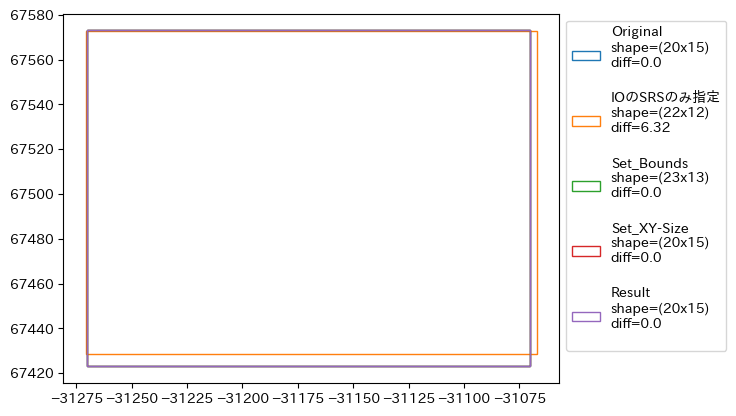

In [39]:
result_dst = reprojection(org_dst, OUT_EPSG)

bounds_dict['Result'] = {
    'bounds': get_local_bounds(result_dst),
    'x_size': result_dst.RasterXSize, 
    'y_size': result_dst.RasterYSize
}

plot_bounds(bounds_dict)